In [30]:
! pip install pyod -q
! pip install suod -q

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')
# ! cp -r /content/drive/MyDrive/Study/MIPT_magistery/qualification_work/data .

In [12]:
import os
import random
import sys
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for statistics
from scipy.stats import kstest

# preprocessing
from sklearn.preprocessing import StandardScaler

# ml methods
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# pyod
# from pyod.models.ecod import ECOD
# from pyod.models.suod import SUOD
# from pyod.models.lof import LOF
# from pyod.models.copod import COPOD
# from pyod.models.iforest import IForest

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)

# Datasets

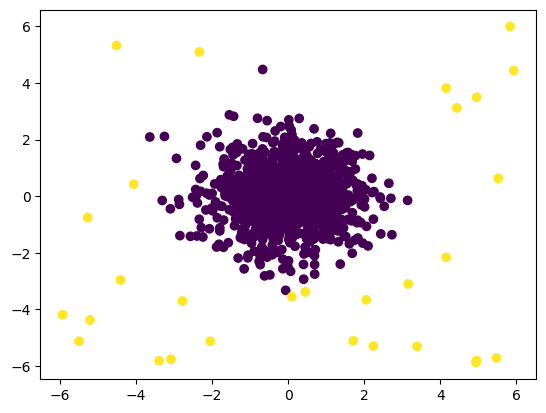

In [16]:
# Синтетически сгенерированные нормально распределенные данные
data_norm = pd.DataFrame(data=np.random.normal(
                        loc=0, scale=1, size=(1000, 2)), 
                       columns=['x', 'y'])
data_noise = pd.DataFrame(data=np.random.uniform(
                        low=-6, high=6, size=(int(data_norm.shape[0]*.05), data_norm.shape[1])), 
                        columns=['x', 'y'])
filter = (
    (data_noise['x'] < data_norm['x'].min())
    | (data_noise['x'] > data_norm['x'].max())
    | (data_noise['y'] < data_norm['y'].min())
    | (data_noise['y'] > data_norm['y'].max())
    )
data_noise = data_noise[filter]
data_norm['anomaly'] = 0
data_noise['anomaly'] = 1

df_norm = pd.concat((data_norm, data_noise))
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.show()

In [53]:
# Синтетически сгенерированные нормально распределенные данные
def make_norm_data(rows, columns, noise_percent=0.05):
    data_norm = pd.DataFrame(data=np.random.normal(
                            loc=0, scale=1, size=(rows, columns)))
    noise = pd.DataFrame(data=np.random.uniform(
                            low=-6, high=6, size=(int(data_norm.shape[0]*noise_percent), data_norm.shape[1])))

    data_noise = pd.DataFrame()
    for feature in noise.columns:
        filter = (
            (noise[feature] < data_norm[feature].min())
            | (noise[feature] > data_norm[feature].max())
            )
        data_noise = pd.concat([data_noise, noise[filter]])
    data_noise = data_noise.drop_duplicates()
    data_norm['anomaly'] = 0
    data_noise['anomaly'] = 1

    df_norm = pd.concat((data_norm, data_noise))
    return df_norm

df_norm = make_norm_data(1000, 8)
df_norm

,0,1,2,3,4,5,6,7,anomaly
0,0.283931,-0.459537,-0.083128,0.485065,-0.415108,-1.837997,1.179401,-0.733550,0
1,-0.304721,0.475120,-1.062746,0.162393,0.648262,0.149089,-0.778318,-1.558251,0
2,-1.601684,-0.183172,1.437003,-0.999174,-0.488020,-0.892090,-0.355491,-0.577820,0
3,-0.503008,-0.153016,-0.988336,0.449462,1.032025,-2.048995,-0.957252,0.082497,0
4,0.258251,-0.324506,0.708224,-0.468856,0.897483,-0.408514,0.797736,0.931714,0
...,...,...,...,...,...,...,...,...,...
33,-2.752834,-2.627571,2.694664,4.680314,0.007826,-0.841195,-0.384103,-5.133260,1
48,1.156104,-2.468022,0.572718,-4.233124,-2.509963,4.397705,-5.855393,2.317455,1
32,0.878810,-0.094955,-1.938812,2.279827,4.176359,-1.465779,0.764982,-2.795325,1
35,-2.524993,2.234060,1.972621,0.267165,5.238989,3.046186,2.881000,1.331775,1


In [34]:
# SKAB data

all_files=[]
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# формируем датафрейм
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    print(path, df.shape)
    dfs.append(df)
print('Features:')
for col in dfs[2].columns:
    print('\t',col)
dfs = [df for df in dfs if df.shape[1] == 10]
df_skab = pd.concat(dfs)
print(df_skab.shape)
df_skab = df_skab.drop_duplicates()
df_skab = df_skab.drop('changepoint', axis=1)
display(df_skab)

data/valve2/2.csv (1129, 10)
data/valve2/1.csv (1063, 10)
data/valve2/0.csv (1125, 10)
data/valve2/3.csv (995, 10)
data/other/2.csv (780, 10)
data/other/14.csv (905, 10)
data/other/1.csv (745, 10)
data/other/10.csv (1327, 10)
data/other/9.csv (1144, 10)
data/other/6.csv (1147, 10)
data/other/4.csv (1191, 10)
data/other/7.csv (1090, 10)
data/other/5.csv (1155, 10)
data/other/8.csv (1147, 10)
data/other/12.csv (1048, 10)
data/other/11.csv (1190, 10)
data/other/3.csv (1137, 10)
data/other/13.csv (923, 10)
data/anomaly-free/anomaly-free.csv (9405, 8)
data/valve1/2.csv (1075, 10)
data/valve1/14.csv (1139, 10)
data/valve1/1.csv (1145, 10)
data/valve1/10.csv (1146, 10)
data/valve1/9.csv (1148, 10)
data/valve1/6.csv (1154, 10)
data/valve1/4.csv (1095, 10)
data/valve1/0.csv (1147, 10)
data/valve1/7.csv (1094, 10)
data/valve1/5.csv (1154, 10)
data/valve1/15.csv (1150, 10)
data/valve1/8.csv (1144, 10)
data/valve1/12.csv (1140, 10)
data/valve1/11.csv (1141, 10)
data/valve1/3.csv (1148, 10)
data/va

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-03-09 16:36:31,0.027334,0.039599,1.283630,0.382638,67.8356,24.2191,232.727,31.0409,0.0
2020-03-09 16:36:32,0.027162,0.040524,0.621886,0.054711,67.8447,24.2318,232.856,32.0000,0.0
2020-03-09 16:36:33,0.027159,0.040818,1.019710,0.054711,67.8444,24.2259,222.798,32.0000,0.0
2020-03-09 16:36:34,0.027328,0.039567,1.148130,0.382638,67.8797,24.2328,230.654,32.0000,0.0
2020-03-09 16:36:36,0.027867,0.039572,1.197150,0.382638,67.9064,24.2308,237.878,32.0000,0.0
...,...,...,...,...,...,...,...,...,...
2020-03-09 14:54:36,0.027120,0.037739,1.040090,-0.273216,65.9516,24.5866,218.878,32.9719,0.0
2020-03-09 14:54:37,0.027453,0.038431,0.736060,0.382638,66.1711,24.5804,248.025,32.0000,0.0
2020-03-09 14:54:38,0.026951,0.038982,0.664913,-0.273216,66.1326,24.5834,220.668,32.0290,0.0


In [35]:
datasets = {
    'df_norm': df_norm,
    'df_skab': df_skab
}

# Статический метод выявления выбросов (3 сигма)

In [39]:
def check_kstest(df, alpha=0.01):
    columns = list(df.columns)
    cols_with_pos_res = []
    for col in columns:
        if kstest(df[col], 'norm').pvalue > alpha:
            cols_with_pos_res.append(col)
    return cols_with_pos_res

def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Признак {feature}. Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    return outliers

def z_score_method(df):
    """
    Метод работает с нормально распределенными данными,
    при чем с небольшим (до 10%) количеством выбросов.
    С ненормально распределенными данными не работает.
    """
    norm_cols = check_kstest(df)
    if norm_cols:
        print('z_score_method')
        outliers = pd.DataFrame()
        for col in norm_cols:
            outliers = pd.concat((outliers, outliers_z_score(df, col)))
        outliers = outliers.drop_duplicates()
        outliers['anomaly_preds'] = 1
        df_with_marked_outliers = df.merge(outliers, how='outer').fillna(0)
        return outliers, df_with_marked_outliers
    else:
        print('The data are not normally distributed')
        return None, df

# Метрики

In [40]:
# f1_score
def score_metrics(real_outliers, pred_outliers):
    scores = {}
    # scores['f1_score'] = f1_score(real_outliers, pred_outliers)
    scores = classification_report(real_outliers, pred_outliers)
    return scores

Ищем выбросы

In [41]:
def stat_method(X, y):
    outliers, X = z_score_method(X)
    if outliers is not None:
        print(score_metrics(y, X['anomaly_preds']))

# ML методы

In [40]:
def preprocessing(df):
    X = df.copy()
    y = X.pop('anomaly')

    # preprocessing
    columns = list(X.columns)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns=columns)
    return X, y

def ml_method(X, y, model, params):
    grid = GridSearchCV(
                estimator=model(),
                param_grid=params,
                scoring='f1_micro',
                return_train_score=True).fit(X, y)
    pred = grid.best_estimator_.predict(X)
    pred[pred == 1] = 0
    pred[pred == -1] = 1
    print(grid.best_estimator_)
    print(score_metrics(y, pred))

In [41]:
ml_models = {}
ml_models['IsolationForest'] = {
    'model': IsolationForest,
    'params': {
        'n_estimators': [50, 100, 500],
        'bootstrap': [True, False],
        }
    }
ml_models['OneClassSVM'] = {
    'model': OneClassSVM,
    'params': {
        'nu': [0.001, 0.01, 0.1, 0.5, 1],
    }
}

In [ ]:
for df_name, df in datasets.items():
    print(df_name)
    X, y = preprocessing(df)
    stat_method(X, y)
    for model in ml_models:
        ml_method(X, y, ml_models[model]['model'], 
                        ml_models[model]['params'])
    print('-' * 10)

df_norm
z_score_method
Признак y. Число выбросов по методу z-отклонения: 19
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       0.95      0.53      0.68        34

    accuracy                           0.98      1034
   macro avg       0.97      0.76      0.84      1034
weighted avg       0.98      0.98      0.98      1034

IsolationForest(bootstrap=True, n_estimators=50)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1000
           1       0.27      1.00      0.43        34

    accuracy                           0.91      1034
   macro avg       0.64      0.95      0.69      1034
weighted avg       0.98      0.91      0.94      1034

OneClassSVM(nu=0.001)
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1000
           1       0.05      0.38      0.09        34

    accuracy                       

In [42]:
clf = ECOD()
clf.fit(df_norm[['x', 'y']])
pred = clf.predict(df_norm[['x', 'y']])
print(score_metrics(df_norm['anomaly'], pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1000
           1       0.33      1.00      0.49        34

    accuracy                           0.93      1034
   macro avg       0.66      0.97      0.73      1034
weighted avg       0.98      0.93      0.95      1034



In [43]:
clf = ECOD()
X, y = preprocessing(df_skab)
clf.fit(X)
pred = clf.predict(X)
print(score_metrics(y, pred))

              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80     23853
         1.0       0.71      0.20      0.31     13067

    accuracy                           0.69     36920
   macro avg       0.70      0.58      0.56     36920
weighted avg       0.69      0.69      0.63     36920



In [44]:
# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
# then clf can be used as any outlier detection model
clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
           verbose=False)

X, y = preprocessing(df_skab)
clf.fit(X)
pred = clf.predict(X)
print(score_metrics(y, pred))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

         0.0       0.68      0.95      0.79     23853
         1.0       0.63      0.17      0.27     13067

    accuracy                           0.67     36920
   macro avg       0.66      0.56      0.53     36920
weighted avg       0.66      0.67      0.61     36920



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   12.2s finished
